### Imports

In [34]:
from __future__ import print_function, division
import os, mimetypes
import torch
import pandas as pd
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from pathlib import Path
from random import shuffle
from scipy import ndimage
from torchsummary import summary
import torch.nn as nn

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
path = Path('C:/Users/francesco.pochetti/Downloads/imagenette')

### Restructure dataset in convenient way

In [4]:
content_path = path/'imagenette-160'

In [5]:
content_path

WindowsPath('C:/Users/francesco.pochetti/Downloads/imagenette/imagenette-160')

In [6]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [7]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res
                
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [8]:
files = get_files(content_path, image_extensions, recurse=True)

In [9]:
len(files)

13394

In [10]:
van_gogh_path = path/'styles'/'VanGoghResized.png' 
van_gogh_path

WindowsPath('C:/Users/francesco.pochetti/Downloads/imagenette/styles/VanGoghResized.png')

In [11]:
contents = files
styles = [van_gogh_path] * len(contents)

In [12]:
te_ = int(len(styles) * 0.2)
tr_ = len(styles) - te_
assert(len(styles) == (te_+tr_))
print(te_, tr_)

splits = ['valid'] * te_ + ['train'] * tr_ 
shuffle(splits)

2678 10716


In [13]:
df = pd.DataFrame({'content_': contents, 'style_': styles, 'split_': splits})
df.head()

,content_,style_,split_
0,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,train
1,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,train
2,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,train
3,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,train
4,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,valid


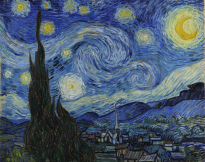

In [14]:
style_img = PIL.Image.open(df.sample().style_.iloc[0]); style_img

In [15]:
(style_img.size + (3,))

(205, 162, 3)

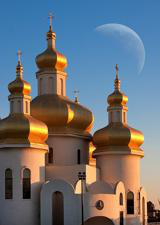

In [16]:
content_img = PIL.Image.open(df.sample().content_.iloc[0]); content_img

In [17]:
df.to_csv(path/'dataset.csv', index=False)

### Prepare the dataset/dataloader

In [18]:
class StyleTransferDataset(Dataset):
    """Style Transfer dataset."""

    def __init__(self, csv_file, train_test, transform=None):
        data = pd.read_csv(csv_file)
        self.train_test = train_test
        data.loc[:,['content_', 'style_']] = data.loc[:,['content_', 'style_']].applymap(lambda x: Path(x))
        self.data = data.loc[data.split_==train_test,:]
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        item = self.__getitem__(0)
        
        _1 = f'{self.train_test.capitalize()} dataset: {len(self.data)} items\n'
        _2 = f'Item: {type(item)} of {len(item)} {type(item[0])}\n'
        _3 = f"Item example: 'input':{ item[0].shape},'content': {item[1].shape}, 'style': {item[2].shape}"

        return _1+_2+_3
    
    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        content_img = self.data.content_.iloc[idx]
        content_img = PIL.Image.open(content_img)
        
        style_img = self.data.style_.iloc[idx]
        style_img = PIL.Image.open(style_img)
        
        opt_img = np.random.uniform(0, 1, size=(content_img.size + (3,))).astype(np.float32)
        opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
        
        item = {'input': PIL.Image.fromarray(np.uint8(opt_img*255)),
                'content': content_img, 
                'style': style_img}

        if self.transform: item = compose(item, self.transform)

        return item['input'], item['content'], item['style']

In [19]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(list(funcs), key=key): x = f(x, **kwargs)
    return x

class Transform(): _order=0
        
class MakeRGB(Transform):
    def __call__(self, item): return {k: v.convert('RGB') for k, v in item.items()}

class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return {k: v.resize(self.size, PIL.Image.BILINEAR) for k, v in item.items()}

class ToByteTensor(Transform):
    _order=20
    def to_byte_tensor(self, item):
        res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
        w,h = item.size
        return res.view(h,w,-1).permute(2,0,1)
    
    def __call__(self, item): return {k: self.to_byte_tensor(v) for k, v in item.items()}


class ToFloatTensor(Transform):
    _order=30
    def to_float_tensor(self, item): return item.float().div_(255.)
    
    def __call__(self, item): return {k: self.to_float_tensor(v) for k, v in item.items()}
    
class Normalize(Transform):
    _order=40
    def __init__(self, stats):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
    
    def normalize(self, item): return item.sub_(self.mean[:, None, None]).div_(self.std[:, None, None])
    
    def __call__(self, item): return {k: self.normalize(v) for k, v in item.items()}
    
class DeProcess(Transform):
    _order=50
    def __init__(self, stats):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
    
    def de_normalize(self, item): return (item*self.std[:, None, None]+self.mean[:, None, None])*255.
    def rearrange_axis(self, item): return np.moveaxis(item, 0, -1)
    def to_np(self, item): return np.uint8(np.array(item))
    def de_process(self, item): return self.rearrange_axis(self.to_np(self.de_normalize(item)))
    
    def __call__(self, item): 
        if isinstance(item, torch.Tensor): return self.de_process(item) 
        if isinstance(item, tuple): return tuple([self.de_process(v) for v in item])
        if isinstance(item, dict): return {k: self.de_process(v) for k, v in item.items()}

In [25]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]
            
def collate(b):
    inputs,contents,styles = zip(*b)
    return torch.stack(inputs),torch.stack(contents),torch.stack(styles)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [137]:
rgb = MakeRGB()
resized = ResizeFixed(128)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats)

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(path/'dataset.csv', train_test='train', transform=tmfs)
valid_ds = StyleTransferDataset(path/'dataset.csv', train_test='valid', transform=tmfs)

In [138]:
valid_ds

Valid dataset: 2678 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 128, 128]),'content': torch.Size([3, 128, 128]), 'style': torch.Size([3, 128, 128])

In [139]:
dataloaders = {'train': DataLoader(train_ds, batch_size=64, shuffle=True),
              'valid': DataLoader(valid_ds, batch_size=64)}

In [22]:
dl = DataLoader(train_ds, batch_size=4, shuffle=True)

In [26]:
sampler = Sampler(train_ds,4,True)
dl = DataLoader(train_ds,sampler)

In [27]:
i,c,s = next(iter(dl))

In [28]:
i.shape, c.shape, s.shape

(torch.Size([4, 3, 128, 128]),
 torch.Size([4, 3, 128, 128]),
 torch.Size([4, 3, 128, 128]))

In [21]:
train_ds

Train dataset: 10716 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 128, 128]),'content': torch.Size([3, 128, 128]), 'style': torch.Size([3, 128, 128])

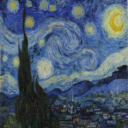

In [64]:
denorm = DeProcess(imagenet_stats)
d = denorm(train_ds[0])
PIL.Image.fromarray(d[2])

In [63]:
type(d)

tuple

### ResNetUnet

In [63]:
#unet.base_model.eval()

In [35]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [36]:
unet = ResNetUNet(3)

In [54]:
x = unet(i)

In [56]:
i.shape

torch.Size([4, 3, 128, 128])

In [58]:
b,c,h,w = i.size()
b,c,h,w

(4, 3, 128, 128)

In [59]:
i.view(b*c, -1).shape

torch.Size([12, 16384])

In [142]:
class SaveFeatures():
    features=None
    
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output): 
        self.features = output
    
    def close(self): 
        self.hook.remove()

def content_mse(input, target):
    return mseloss(input, target)

def content_loss(x, target_act, l=None):
    model(x)
    opt_act = [o.features.clone() for o in activations]
    if l is None:
        losses = [content_mse(o, s) for o,s in zip(opt_act, target_act)]
        return sum(losses)
    else:
        return content_mse(opt_act[l], target_act[l])

def gram(input):
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()

def gram_mse_loss(input, target): 
    return mseloss(gram(input), gram(target))

def style_loss(x, target_act, l=None):
    model(x)
    opt_act = [o.features.clone() for o in activations]
    if l is None:
        losses = [gram_mse_loss(o, s) for o,s in zip(opt_act, target_act)]
        return sum(losses)
    else:
        return gram_mse_loss(opt_act[l], target_act[l])    

In [94]:
model = models.vgg16_bn(pretrained=True)
model = model.eval()
#model.features

In [91]:
convs = [i-3 for i,o in enumerate(list(model.features)) if isinstance(o,nn.MaxPool2d)]
print(np.array(list(model.features))[convs])

[Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


In [110]:
input = train_ds[0][0][None]
original_t = train_ds[0][1]
style_t = train_ds[0][2]

In [97]:
activations = [SaveFeatures(list(model.features)[idx]) for idx in convs]

In [99]:
model(original_t[None])
target_cont = [o.features.clone() for o in activations]

model(style_t[None])
target_style = [o.features.clone() for o in activations]

In [103]:
[t.shape for t in target_style]

[torch.Size([1, 64, 128, 128]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16]),
 torch.Size([1, 512, 8, 8])]

In [124]:
mseloss = nn.MSELoss()

In [132]:
content_loss(input, target_cont)

tensor(0.7885, grad_fn=<AddBackward0>)

In [133]:
style_loss(input, target_style)

tensor(2.5175e-06, grad_fn=<AddBackward0>)

In [131]:
combined_loss(input, target_style, target_cont)

tensor(0.3942, grad_fn=<AddBackward0>)

In [64]:
#summary(unet, input_size=(3, 128, 128))

In [136]:
import time
import torch.optim as optim
from torch.optim import lr_scheduler

In [141]:
for i,c,s in dataloaders['train']:
    print(i.shape, c.shape, s.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 128, 128])


In [143]:
def combined_loss(opt_cat, target_style, target_cont, lam=0.5):
    style_losses = [gram_mse_loss(o, s) for o,s in zip(opt_act, target_style)]
    #content_losses = [content_mse(opt_act[2], target_cont[2])/1e3]
    content_losses = [content_mse(o, s) for o,s in zip(opt_act, target_cont)]
    style = sum(style_losses)
    content = sum(content_losses)
    return (1-lam)*content + lam*style

In [ ]:
#def train_model(model, optimizer, scheduler, num_epochs=25):
num_epochs = 1
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10
model = unet

    model(x)
    opt_act = [o.features.clone() for o in activations]

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])

            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        metrics = defaultdict(float)
        epoch_samples = 0

        for inputs, contents, styles in dataloaders[phase]:
            inputs = inputs.to(device)
            contents = contents.to(device)
            styles = styles.to(device)
            
            vgg(contents[None])
            target_cont = [o.features.clone() for o in activations]

            vgg(styles[None])
            target_style = [o.features.clone() for o in activations]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                
                vgg(outputs[None])
                opt_act = [o.features.clone() for o in activations]
                
                loss = combined_loss(opt_cat, target_style, target_cont)
                #loss = calc_loss(outputs, labels, metrics)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)

        print_metrics(metrics, epoch_samples, phase)
        epoch_loss = metrics['loss'] / epoch_samples

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            print("saving best model")
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

print('Best val loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)
return model